<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Deep-Q-Network-(DQN)" data-toc-modified-id="Deep-Q-Network-(DQN)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Deep Q-Network (DQN)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#1.-Import-the-Necessary-Packages" data-toc-modified-id="1.-Import-the-Necessary-Packages-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>1. Import the Necessary Packages</a></span></li><li><span><a href="#2.-Instantiate-the-Environment-and-Agent" data-toc-modified-id="2.-Instantiate-the-Environment-and-Agent-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>2. Instantiate the Environment and Agent</a></span></li><li><span><a href="#3.-Train-the-Agent-with-DQN" data-toc-modified-id="3.-Train-the-Agent-with-DQN-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>3. Train the Agent with DQN</a></span></li><li><span><a href="#4.-Watch-a-Smart-Agent!" data-toc-modified-id="4.-Watch-a-Smart-Agent!-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>4. Watch a Smart Agent!</a></span></li><li><span><a href="#5.-Explore" data-toc-modified-id="5.-Explore-1.0.5"><span class="toc-item-num">1.0.5&nbsp;&nbsp;</span>5. Explore</a></span></li></ul></li></ul></li></ul></div>

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


# Project: Navigation
---
In this notebook, I implement a solution for the navigation project of the Udacity class.

### 1. Import the Necessary Packages

In [2]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [3]:
from unityagents import UnityEnvironment

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

state = env_info.vector_observations[0]

print('State shape: ', state.shape)
print('Number of actions:', brain.vector_action_space_size)
print('Example of a state: ', env_info.vector_observations[0])

State shape:  (37,)
Number of actions: 4
Example of a state:  [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]


Instantiating the Agent interface

In [5]:
def environment_step(env, action, brain_name):
    env_info = env.step(action)[brain_name]
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0] 
    
    return next_state, reward, done, None

def environment_reset(env, brain_name):
    env = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env.vector_observations[0]            # get the current state
    
    return state

In [6]:
from datetime import datetime
def get_time():
    now = datetime.now()

    return now.strftime("%H:%M:%S")

In [34]:
import prioritizedAgent
import importlib

importlib.reload(prioritizedAgent)

#agent = prioritizedAgent.PrioritizingAgent(state_size=37, action_size=4, seed=0)

import agent
#importlib.reload(agent)

#agent = agent.Agent(state_size=37, action_size=4, seed=0)

state = environment_reset(env, brain_name)

for j in range(200):
    action = agent.act(state)
    state, reward, done, _ = environment_step(env, action, brain_name)
    #print(reward)
    if done:
        break 
        
#env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Alternatively, you can skip to the next step below (**4. Watch a Smart Agent!**), to load the saved model weights from a pre-trained agent.

Episode 100	Average Score: 0.62	Time: 17:41:05
Episode 200	Average Score: 3.14	Time: 17:48:32
Episode 300	Average Score: 7.29	Time: 17:57:41
Episode 400	Average Score: 10.42	Time: 18:08:01
Episode 500	Average Score: 12.77	Time: 18:18:35
Episode 514	Average Score: 13.02	Time: 18:20:04
Environment solved in 414 episodes!	Average Score: 13.02


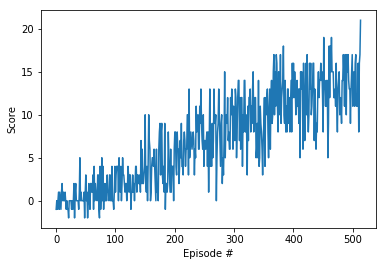

In [35]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = environment_reset(env, brain_name)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = environment_step(env, action, brain_name)
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tTime: {}'.format(i_episode, np.mean(scores_window), get_time()), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(3):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  